In [1]:
import pytz
import os
import sqlite3
import re
import uproot
import IPython
import sys
import numpy as np
import pandas as pd
import pymap3d as pm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pandasql import sqldf
from rnog_data.runtable import RunTable
from datetime import datetime, timedelta
from scipy.fft import fft
from scipy.signal import stft
from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units
from Flight import Flight
from IPython.display import clear_output

## FlightTracker init

In [2]:
#-------------------------------------------------------------------------------------------------
#-------------------------------------------------------------------------------------------------
from FlightTracker import FlightTracker

start_time='2023-01-01 00:00:00'
stop_time='2024-01-01 00:00:00'
tracker = FlightTracker(start_time, stop_time, destination='./flights/flights_2023.db')
flights = tracker.flights
flights_distinct = tracker.flights_distinct
flights_distinct

start 2023.07.03-234818.db
end 2023.07.03-234818.db


In [ ]:
flights

,index,id,latitude,longitude,altitude,seen,rssi,flightnumber,hexcode,track,speed,vertrate,readtime,date,filename,x,y,z,r2,readtime_utc
0,3293515,None,73.775381,-37.498352,34000.0,0.3,-22.9,CLX17K,4d0118,290.0,507.0,0.0,2023-01-01 01:07:57.300000,2023-01-01,2023.01.01-040336.db,105.868274,105.109614,8.619667,22330.420852,2023-01-01 01:07:57.300000+00:00
1,3293518,None,73.778966,-37.535339,34000.0,0.2,-24.4,CLX17K,4d0118,290.0,507.0,64.0,2023-01-01 01:08:02.300000,2023-01-01,2023.01.01-040336.db,106.133335,100.994595,8.681865,21539.567889,2023-01-01 01:08:02.300000+00:00
2,3293521,None,73.782852,-37.575645,34000.0,0.0,-23.1,CLX17K,4d0118,290.0,507.0,0.0,2023-01-01 01:08:07.300000,2023-01-01,2023.01.01-040336.db,106.419943,96.510256,8.746641,20715.937616,2023-01-01 01:08:07.300000+00:00
3,3293524,None,73.786972,-37.618389,34000.0,0.2,-23.9,CLX17K,4d0118,290.0,507.0,0.0,2023-01-01 01:08:12.400000,2023-01-01,2023.01.01-040336.db,106.723331,91.754577,8.811881,19886.421049,2023-01-01 01:08:12.400000+00:00
4,3293527,None,73.790817,-37.657871,34000.0,0.2,-24.6,CLX17K,4d0118,290.0,507.0,0.0,2023-01-01 01:08:17.400000,2023-01-01,2023.01.01-040336.db,107.006625,87.361695,8.868925,19161.141372,2023-01-01 01:08:17.400000+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410601,572141,None,71.929864,-39.554820,37000.0,0.0,-23.7,VIR105,4073ce,298.0,478.0,-64.0,2023-12-31 16:19:02.300000,2023-12-31,2023.12.31-171747.db,-55.973929,-123.059508,9.844260,18373.632596,2023-12-31 16:19:02.300000+00:00
410602,572143,None,71.934939,-39.586487,36975.0,0.0,-21.4,VIR105,4073ce,298.0,479.0,-64.0,2023-12-31 16:19:07.400000,2023-12-31,2023.12.31-171747.db,-55.511686,-126.577629,9.771736,19198.930244,2023-12-31 16:19:07.400000+00:00
410603,572145,None,71.939966,-39.618153,36975.0,0.0,-20.5,VIR105,4073ce,298.0,479.0,-64.0,2023-12-31 16:19:12.400000,2023-12-31,2023.12.31-171747.db,-55.054019,-130.095822,9.704816,20050.051446,2023-12-31 16:19:12.400000+00:00
410604,572147,None,71.944885,-39.649200,37000.0,0.0,-22.2,VIR105,4073ce,298.0,479.0,-64.0,2023-12-31 16:19:17.400000,2023-12-31,2023.12.31-171747.db,-54.606566,-133.545414,9.644893,20909.278605,2023-12-31 16:19:17.400000+00:00


In [ ]:
header_df = pd.DataFrame(columns = ['trigger_time', 'station_number', 'radiant_triggers'])
path = 'header'
i = 0

for filename in os.listdir('./header/'):
    print(filename, i)
    try:
        file = uproot.open(f"{path}/" + filename)
        temp_df = pd.DataFrame()
        
        '''
        # make mask to slice all data
        times = pd.to_datetime(np.array(file[path]['header/trigger_time']), unit = 's')
        mask = (times >= pd.to_datetime(start_time).tz_convert(None)) & (times <= pd.to_datetime(stop_time).tz_convert(None))

        # header information
        temp_df['station_number'] = np.array(file[path]['header/station_number'])[mask]
        temp_df['run_number'] = np.array(file[path]['header/run_number'])[mask]
        temp_df['event_number'] = np.array(file[path]['header/event_number'])[mask]
        temp_df['trigger_time'] = np.array(file[path]['header/trigger_time'])[mask]
        temp_df['radiant_triggers'] = np.array(file[path]['header/trigger_info/trigger_info.radiant_trigger'])[mask]
        temp_df['lt_triggers'] = np.array(file[path]['header/trigger_info/trigger_info.lt_trigger'])[mask]
        run_nr = np.array(file[path]['header/run_number'])[0]
        # combinded (waveform) information
        '''

    #            header information
        temp_df['station_number'] = np.array(file[path]['header/station_number'])
        temp_df['run_number'] = np.array(file[path]['header/run_number'])
        temp_df['event_number'] = np.array(file[path]['header/event_number'])
        temp_df['trigger_time'] = np.array(file[path]['header/trigger_time'])
        temp_df['radiant_triggers'] = np.array(file[path]['header/trigger_info/trigger_info.radiant_trigger'])
        temp_df['lt_triggers'] = np.array(file[path]['header/trigger_info/trigger_info.lt_trigger'])
        temp_df['force_triggers'] = np.array(file[path]['header/trigger_info/trigger_info.force_trigger'])
        temp_df['ext_triggers'] = np.array(file[path]['header/trigger_info/trigger_info.ext_trigger'])
        run_nr = np.array(file[path]['header/run_number'])[0]


        # save header information
        if len(header_df) == 0:
            header_df = temp_df
        else:
            header_df = pd.concat([header_df, temp_df], ignore_index=True, sort=False)
        i += 1
    except:
        print(f"can't open {filename}")

# since we are processing whole file again in order to save the scores, we need to filter for desired time interval
#header_df = header_df[(header_df.trigger_time >= start_time.timestamp()) & (stop_time.timestamp() >= header_df.trigger_time)]
#header_df['i'] = range(0, len(header_df))

#header_df = header_df[['i', 'station_number', 'run_number', 'event_number', 'trigger_time', 'radiant_triggers', 'lt_triggers', 'force_triggers']] # change order to have index in front



station13_run1433_headers.root 0
station23_run1459_headers.root 1
station24_run2203_headers.root 2
station24_run2574_headers.root 3
station11_run3238_headers.root 4
station12_run1261_headers.root 5
station24_run1323_headers.root 6
station21_run2786_headers.root 7
station21_run3180_headers.root 8
station24_run2529_headers.root 9
station21_run3292_headers.root 10
station23_run1454_headers.root 11
station21_run3418_headers.root 12
station23_run1271_headers.root 13
station23_run2435_headers.root 14
station11_run2106_headers.root 15
station13_run2666_headers.root 16
station24_run1690_headers.root 17
station21_run3730_headers.root 18
station12_run1672_headers.root 19
station23_run1632_headers.root 20
station23_run2985_headers.root 21
station21_run2410_headers.root 22
station23_run3213_headers.root 23
station11_run2180_headers.root 24
station23_run2235_headers.root 25
station12_run1846_headers.root 26
station21_run4252_headers.root 27
station13_run2899_headers.root 28
station11_run2071_header

In [ ]:
header_df

,station_number,run_number,event_number,trigger_time,radiant_triggers,lt_triggers,force_triggers,ext_triggers
0,13,1433,0,1.684792e+09,True,False,False,False
1,13,1433,1,1.684792e+09,False,True,False,False
2,13,1433,2,1.684792e+09,False,False,True,False
3,13,1433,3,1.684792e+09,False,True,False,False
4,13,1433,4,1.684792e+09,False,True,False,False
...,...,...,...,...,...,...,...,...
51041289,11,2786,867,1.688674e+09,True,False,False,False
51041290,11,2786,868,1.688674e+09,True,False,False,False
51041291,11,2786,869,1.688674e+09,True,False,False,False
51041292,11,2786,870,1.688674e+09,True,False,False,False


In [6]:
query = '''
SELECT 
    *
FROM header_df


'''
sqldf(query)

: 

In [5]:
# This cell crashes the kernel
'''
con = sqlite3.connect('./distinct_table_with_header_scores/all_header_2023')

# Write the DataFrame to the SQLite database
header_df.to_sql('header_df_2023-09-01', con, if_exists = 'replace')
# Close the database connection
con.close()
'''

: 

## Number of flights per airline (in radius)

In [5]:
radius = 50
query = f'''
SELECT 
    airline
    ,count(airline)
FROM (
    SELECT 
        substr(flightnumber, 1, 3) as airline 
    FROM flights_distinct
    WHERE min_r < {radius}
)t0
GROUP BY airline
ORDER BY count(airline) desc

'''

result = sqldf(query)
result.head(10)

,airline,count(airline)
0,DLH,27
1,THY,17
2,CFG,14
3,SAS,12
4,AFR,9
5,KLM,7
6,BAW,5
7,QTR,4
8,DAL,4
9,UAE,3


## Get trajectories for 1 airline

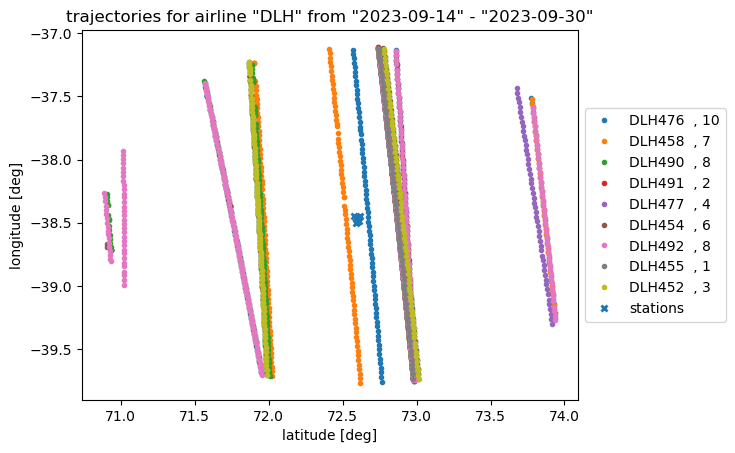

In [7]:
airline = 'DLH'
flights_one_airline = flights[flights.flightnumber.str.startswith(airline)]
flights_one_airline_distinct = flights_distinct[flights_distinct.flightnumber.str.startswith(airline)]

flightnumbers = sqldf(f'Select distinct flightnumber from flights_one_airline_distinct where min_r < {radius}')

for i in range(len(flightnumbers)):
    number_of_flights = sqldf(f'Select count(flightnumber) as counter from flights_one_airline_distinct Where flightnumber like "%{flightnumbers.flightnumber.iloc[i]}%" group By flightnumber')
    plt.plot(flights_one_airline[flights_one_airline.flightnumber == flightnumbers.flightnumber.iloc[i]].latitude, flights_one_airline[flights_one_airline.flightnumber == flightnumbers.flightnumber.iloc[i]].longitude, '.', label = f'{flightnumbers.flightnumber.iloc[i]}, {number_of_flights.counter.iloc[0]}')
plt.plot(tracker.stations.latitude, tracker.stations.longitude, 'x', label = 'stations', markersize = 5, markeredgewidth=2, c = 'C0')
plt.title(f'trajectories for airline "{airline}" from "{min(flights_one_airline.date)}" - "{max(flights_one_airline.date)}"')
plt.xlabel('latitude [deg]')
plt.ylabel('longitude [deg]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Number of flights per day (for 4 radii)

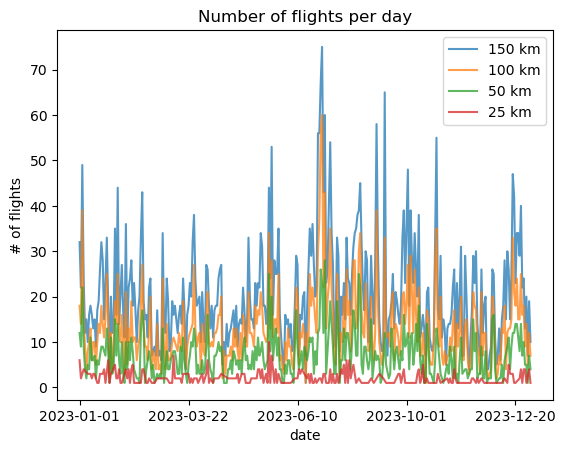

In [7]:
def query(min_r):

    return f'''
    Select 
        date, 
        count(flightnumber) as counter
    from flights_distinct
    Where min_r < {min_r}
    Group By date
    '''

import matplotlib.ticker as ticker
for i in [150, 100, 50, 25]:
    flights_per_day = sqldf(query(i))
    plt.plot(flights_per_day.date, flights_per_day.counter, label = f'{i} km', alpha = 0.75)
    plt.title('Number of flights per day')
plt.xlabel('date')
plt.ylabel('# of flights')
plt.legend()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
#plt.savefig('saved_figures/flights_per_day_2023.pdf')

# Analysis of trigger rates from header files


In [8]:
t = flights_distinct.reset_index(drop=True)
temp_df = pd.DataFrame()


for i in range(len(t)):
    print(f'---------------------')
    print(f'start: {i + 1}/{len(t)}, {t.flightnumber.iloc[i]}')
    f = tracker.get_flight_by_index(i, filetype='headers.root')
    flight = f.header_df.reset_index(drop=True)
    #flight['fk_station_run_event'] = flight.station_number.astype(str) + '_' + flight.run_number.astype(str) + '_' + flight.event_number.astype(str)
    #print(flight.head(50))

    if len(flight) > 0:
        temp_df = pd.concat([temp_df, flight], ignore_index=True, sort=False)
    
    print(f'end: {i + 1}/{len(t)}')
    clear_output(wait=True)

#print(len(temp_df))
#temp_df.drop_duplicates(subset=['fk_station_run_event'], inplace=True)
#print(len(temp_df))
#temp_df.head(50)

query = '''
    Select 
        flightnumber, 
        mintime, 
        maxtime, 
        min_r,
        min_z,
        theta
        --strftime('%Y-%m-%d %H:%M:%S.%f', datetime(temp_df.trigger_time, 'unixepoch')) as test_time, 
        count(*) as SumEvents, 
        round(count(*) / (JULIANDAY(t.maxtime) - JULIANDAY(t.mintime)) / 86400 * 10, 1) as EventsPer10Seconds,
        --sum(cw), 
        --sum(impulsive), 
        sum(lt_triggers), 
        sum(radiant_triggers), 
        sum(force_triggers) 
    From t
    Left Join temp_df
    On strftime('%Y-%m-%d %H:%M:%S.%f', datetime(temp_df.trigger_time, 'unixepoch')) >= t.mintime
    And strftime('%Y-%m-%d %H:%M:%S.%f', datetime(temp_df.trigger_time, 'unixepoch')) <= t.maxtime
    Group By flightnumber, maxtime, mintime
    order by mintime asc
    '''
t = sqldf(query)
clear_output(wait=True)
t


---------------------
start: 4404/6895, N/A


ValueError: cannot mmap an empty file

In [34]:
query = '''
SELECT 
    airline
    ,round(Sum(SumEvents) / Sum(duration_in_min), 1) events_per_minute
    ,time
FROM (
    SELECT 
        *
        --,CASE WHEN (time >= '20:00:00') OR (time < '06:00:00') THEN 1 ELSE 0 END AS nighttime
        ,CASE WHEN (time < '20:00:00') OR (time >= '06:00:00') THEN 1 ELSE 0 END AS daytime
    FROM (
        SELECT 
            substr(flightnumber, 1, 3) as airline
            ,SumEvents
            ,round((JULIANDAY(t.maxtime) - JULIANDAY(t.mintime)) * 1440, 1) as duration_in_min
            ,time(t.mintime) as time
        FROM t
        Where substr(flightnumber, 1, 3) = 'UAL'
    )t0
)t1
WHERE daytime = 1
Group by airline
'''
result = sqldf(query)
result

,airline,events_per_minute,time
0,UAL,279.3,13:10:24


In [35]:
query = '''
SELECT 
    *
 FROM t
 Where  substr(flightnumber, 1, 3) = 'UAL'
 Order by mintime desc
'''

result = sqldf(query)
result.head(49)

,flightnumber,mintime,maxtime,SumEvents,EventsPer10Seconds,sum(lt_triggers),sum(radiant_triggers),sum(force_triggers)
0,UAL927,2023-09-30 20:10:32.300000,2023-09-30 20:11:37.600000,188,28.8,121.0,34.0,33.0
1,UAL969,2023-09-30 16:50:54.000000,2023-09-30 16:52:14.400000,229,28.5,150.0,39.0,40.0
2,UAL45,2023-09-30 16:32:38.700000,2023-09-30 16:33:44.000000,195,29.9,127.0,35.0,33.0
3,UAL927,2023-09-29 19:45:09.800000,2023-09-29 19:46:30.200000,228,28.4,150.0,38.0,40.0
4,UAL969,2023-09-29 16:50:49.000000,2023-09-29 16:52:09.400000,230,28.6,155.0,35.0,40.0
5,UAL939,2023-09-29 16:46:42.800000,2023-09-29 16:48:38.300000,388,33.6,253.0,78.0,57.0
6,UAL45,2023-09-29 16:18:19.500000,2023-09-29 16:19:19.800000,353,58.5,220.0,73.0,60.0
7,UAL59,2023-09-29 16:04:35.500000,2023-09-29 16:05:05.600000,78,25.9,53.0,10.0,15.0
8,UAL949,2023-09-29 14:56:55.800000,2023-09-29 14:58:01.100000,197,30.2,134.0,31.0,32.0
9,UAL195,2023-09-29 14:21:35.500000,2023-09-29 14:23:00.900000,241,28.2,176.0,23.0,42.0


In [13]:
        con = sqlite3.connect('./distinct_table_with_header_scores/2023-09-01')

        # Write the DataFrame to the SQLite database
        t.to_sql('flights_distinct_2023-09-01', con, if_exists = 'replace')
        temp_df.to_sql('header_df_2023-09-01', con, if_exists = 'replace')
        # Close the database connection
        con.close()

In [4]:
%tb header/trigger_info/trigger_info.radiant_trigger

SystemExit: No runs from "2023-01-01 01:07:57+00:00" to "2023-01-01 01:11:38+00:00"

# Analysis of events for '2023-05-12'

## Get event information

In [11]:
track = FlightTracker('2023-05-12 00:00:00') 

t = track.flights_distinct.reset_index(drop=True)
temp_df = pd.DataFrame()


for i in range(len(t)):
    print(f'---------------------')
    print(f'start: {i + 1}/{len(t)}, {t.flightnumber.iloc[i]}')
    f = track.get_flight_by_index(i)
    flight = f.header_df.reset_index(drop=True)
    flight['fk_station_run_event'] = flight.station_number.astype(str) + '_' + flight.run_number.astype(str) + '_' + flight.event_number.astype(str)
    #print(flight.head(50))

    if len(flight) > 0:
        temp_df = pd.concat([temp_df, flight], ignore_index=True, sort=False)
    
    print(f'end: {i + 1}/{len(t)}')
    clear_output(wait=True)

print(len(temp_df))
temp_df.drop_duplicates(subset=['fk_station_run_event'], inplace=True)
print(len(temp_df))
#temp_df.head(50)

query = '''
    Select 
        flightnumber, 
        mintime, 
        maxtime, 
        --strftime('%Y-%m-%d %H:%M:%S.%f', datetime(temp_df.trigger_time, 'unixepoch')) as test_time, 
        count(*) as SumEvents, 
        round(count(*) / (JULIANDAY(t.maxtime) - JULIANDAY(t.mintime)) / 86400 * 10, 1) as EventsPer10Seconds,
        sum(cw), 
        sum(impulsive), 
        sum(lt_triggers), 
        sum(radiant_triggers), 
        sum(force_triggers) 
    From t
    Left Join temp_df
    On strftime('%Y-%m-%d %H:%M:%S.%f', datetime(temp_df.trigger_time, 'unixepoch')) >= t.mintime
    And strftime('%Y-%m-%d %H:%M:%S.%f', datetime(temp_df.trigger_time, 'unixepoch')) <= t.maxtime
    Group By flightnumber, maxtime, mintime
    order by mintime asc
    '''
t = sqldf(query)
clear_output(wait=True)
t


,flightnumber,mintime,maxtime,SumEvents,EventsPer10Seconds,sum(cw),sum(impulsive),sum(lt_triggers),sum(radiant_triggers),sum(force_triggers)
0,MMD6260,2023-05-12 00:59:33.000000,2023-05-12 01:03:19.100000,46,2.0,0,3,32,4,10
1,THY8JK,2023-05-12 07:05:09.600000,2023-05-12 07:11:06.400000,106,3.0,0,0,70,19,17
2,THY76Y,2023-05-12 07:24:30.300000,2023-05-12 07:25:30.600000,10,1.7,0,0,6,3,1
3,THY8MT,2023-05-12 11:12:41.800000,2023-05-12 11:18:43.600000,140,3.9,39,10,88,26,26
4,THY73G,2023-05-12 11:19:18.800000,2023-05-12 11:25:15.500000,96,2.7,43,13,53,23,20
5,SAS931,2023-05-12 11:19:43.900000,2023-05-12 11:25:15.500000,90,2.7,39,12,49,22,19
6,DAL143,2023-05-12 11:57:24.900000,2023-05-12 11:58:25.200000,14,2.3,0,0,10,0,4
7,OCN72,2023-05-12 12:40:07.300000,2023-05-12 12:46:14.100000,117,3.2,16,14,81,23,13
8,DLH456,2023-05-12 13:06:20.000000,2023-05-12 13:11:56.600000,107,3.2,0,12,71,20,16
9,DAL179,2023-05-12 13:17:18.200000,2023-05-12 13:23:25.000000,134,3.7,17,13,98,22,14


## Join events on flights

In [12]:
query = '''
SELECT 
    *
    ,round(sum(SumEvents) / [sum(duration_in_min)], 1) as events_per_minute
    ,round([sum(cw)] / [sum(duration_in_min)], 1) as cw_per_minute
    ,round([sum(impulsive)] / [sum(duration_in_min)], 1) as impulsive_per_minute
    
FROM (
    SELECT 
        airline
        ,count(airline)
        ,sum([sum(cw)]) as [sum(cw)]
        ,sum([sum(impulsive)]) as [sum(impulsive)]
        ,sum(SumEvents) as SumEvents
        ,sum(duration_in_min) as [sum(duration_in_min)]
    FROM (
        SELECT 
            substr(flightnumber, 1, 3) as airline
            ,[sum(cw)]
            ,[sum(impulsive)]
            ,SumEvents
            ,round((JULIANDAY(t.maxtime) - JULIANDAY(t.mintime)) * 86400 / 60, 1) as duration_in_min
        FROM t
        --WHERE min_r < 50
    )t0
    GROUP BY airline 
)t1
    GROUP BY airline
    ORDER BY round([sum(impulsive)] / [sum(duration_in_min)], 1) desc
'''

result = sqldf(query)
result.head(49)

,airline,count(airline),sum(cw),sum(impulsive),SumEvents,sum(duration_in_min),events_per_minute,cw_per_minute,impulsive_per_minute
0,CFG,1,4,32,122,6.1,20.0,0.7,5.2
1,N/A,1,0,1,9,0.3,30.0,0.0,3.3
2,PIA,1,0,19,104,6.3,16.5,0.0,3.0
3,SAS,2,39,34,196,11.6,16.9,3.4,2.9
4,THY,6,82,71,567,30.7,18.5,2.7,2.3
5,OCN,1,16,14,117,6.1,19.2,2.6,2.3
6,DLH,3,6,40,349,17.8,19.6,0.3,2.2
7,SKI,1,620,163,2067,93.6,22.1,6.6,1.7
8,DAL,3,87,23,331,14.3,23.1,6.1,1.6
9,UAL,1,2,5,54,3.7,14.6,0.5,1.4


## Plot flights

In [13]:
track.flights_distinct

,index,flightnumber,date,filename,mintime,maxtime,min_r,min_z,theta
0,0,THY8JK,2023-05-12,2023.05.13-051443.db,2023-05-12 07:05:09.600000,2023-05-12 07:11:06.400000,24.8,9.5,86.0
1,1,THY76Y,2023-05-12,2023.05.13-051443.db,2023-05-12 07:24:30.300000,2023-05-12 07:25:30.600000,148.1,9.5,85.0
2,2,THY8MT,2023-05-12,2023.05.13-051443.db,2023-05-12 11:12:41.800000,2023-05-12 11:18:43.600000,27.6,8.6,86.0
3,3,THY73G,2023-05-12,2023.05.13-051443.db,2023-05-12 11:19:18.800000,2023-05-12 11:25:15.500000,27.7,10.2,86.0
4,4,SAS931,2023-05-12,2023.05.13-051443.db,2023-05-12 11:19:43.900000,2023-05-12 11:25:15.500000,56.4,9.9,87.0
5,5,DAL143,2023-05-12,2023.05.13-051443.db,2023-05-12 11:57:24.900000,2023-05-12 11:58:25.200000,148.0,9.5,85.0
6,6,OCN72,2023-05-12,2023.05.13-051443.db,2023-05-12 12:40:07.300000,2023-05-12 12:46:14.100000,27.4,9.2,86.0
7,7,DLH456,2023-05-12,2023.05.13-051443.db,2023-05-12 13:06:20.000000,2023-05-12 13:11:56.600000,57.6,8.9,87.0
8,8,DAL179,2023-05-12,2023.05.13-051443.db,2023-05-12 13:17:18.200000,2023-05-12 13:23:25.000000,72.8,9.5,82.0
9,9,DLH490,2023-05-12,2023.05.13-051443.db,2023-05-12 13:37:34.100000,2023-05-12 13:43:50.900000,27.6,9.8,86.0


/home/oliver/software/Flights/Flight.py:220: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  header_df = pd.concat([header_df, temp_df], ignore_index=True, sort=False)


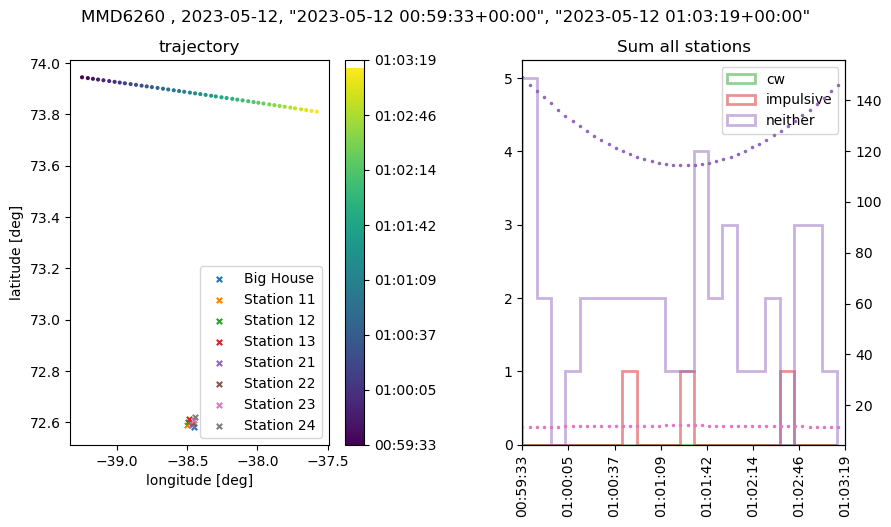

In [14]:
flight = track.get_flight_by_index(21)
flight.plot_flight()